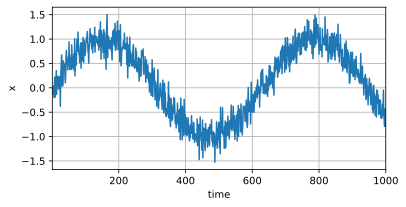

In [4]:
#%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=d2l.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [10]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size, is_train=True)

In [34]:
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net=nn.Sequential(nn.Linear(4,10),
    nn.ReLU(),
    nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss=nn.MSELoss()#默认 MSE Loss就是取平均的，取平均就是为了方便batch数据的反向传播

In [37]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)#需要记清楚，loss fuction里面给的参数
            #有mean和没mean差别比较大，有mean 最后输出的数据就是一个标量，
            #可以直接反向传播，如果没有mean，出来的就是一个向量，不能反向传播，成了
            #雅克比了
            #print(l)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.072977
epoch 2, loss: 0.058798
epoch 3, loss: 0.057001
epoch 4, loss: 0.055809
epoch 5, loss: 0.055191


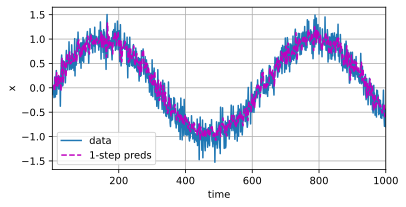

In [38]:
onestep_preds = net(features)#feature的数据格式是996*4
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

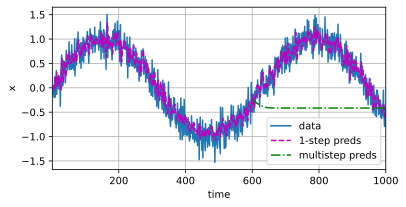

In [41]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

这里的d2l.plot函数传进去的的三个 x y z都是对应的， x是所有数据  y是正确步预测 对应的是4,1000,多步预测
是600-100 这样子，其实也可以从tau以后开始，先用4个数据预测，第一个点最准确，后面的都不准了